# QHack 2023 - Team Durchmusterung


## QSVM for Star Classification: A Case Study on White Dwarf and Giant Stars

### Member: Louis Chen, Felix Xu, Henry Makhanov

In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 0 - Importing Libraries

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, jaccard_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

'''
For further versions, it would be interesting to implement a Neural Network.

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
'''

'\nFor further versions, it would be interesting to implement a Neural Network.\n\nimport torch\nimport torch.nn as nn\nimport torch.optim as optim\nimport torch.nn.functional as F\nfrom torch.utils.data import DataLoader, TensorDataset\nimport torchvision.transforms as transforms\n'

# 1 - Importing & analyzing the dataset

First of all let's import the dataset and let's check the type of data, the missing values and also we are going to take a look at the different categorical variables.

In [4]:
import pandas as pd

stars_df = pd.read_csv('Star3642_balanced.csv')
stars_df

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass
0,8.23,2.72,1.01,1.294,K2/K3III,15.402843,0
1,7.95,6.12,0.97,1.067,K0III-IV,16.883757,1
2,9.44,5.68,4.61,0.439,F3V,18.211742,1
3,6.93,0.65,0.66,0.240,B0.5III,10.994566,0
4,6.82,2.82,0.74,1.273,G8/K0III,14.071245,0
...,...,...,...,...,...,...,...
3637,8.20,9.41,1.53,0.500,F5V,18.067947,1
3638,7.41,0.57,1.03,1.389,K2III,11.189374,0
3639,8.74,1.81,1.25,0.980,G8III,15.028393,0
3640,6.15,2.93,0.82,1.652,M0III,13.484339,0


In [15]:
stars_df.describe()

,Vmag,Plx,e_Plx,B-V,Amag,TargetClass
count,3642.000000,3642.000000,3642.000000,3642.000000,3642.000000,3642.000000
mean,8.120530,7.606153,1.176568,0.827077,16.427388,0.500000
std,1.338875,11.924052,0.919999,0.436699,2.428144,0.500069
min,0.450000,-6.820000,0.470000,-0.196000,2.820000,0.000000
25%,7.370000,2.740000,0.840000,0.487250,15.150312,0.000000
50%,8.390000,4.950000,1.040000,0.867000,16.392485,0.500000
75%,9.060000,8.670000,1.270000,1.136000,18.029836,1.000000
max,12.490000,280.270000,30.290000,2.530000,29.249165,1.000000


In [16]:
stars_df.dtypes

Vmag           float64
Plx            float64
e_Plx          float64
B-V            float64
SpType          object
Amag           float64
TargetClass      int64
dtype: object

In [17]:
null, nan = stars_df.isnull().sum() , stars_df.isna().sum()
print(null)
print(nan)

Vmag           0
Plx            0
e_Plx          0
B-V            0
SpType         0
Amag           0
TargetClass    0
dtype: int64
Vmag           0
Plx            0
e_Plx          0
B-V            0
SpType         0
Amag           0
TargetClass    0
dtype: int64


In [18]:
unique_count = stars_df['SpType'].nunique()
print("Number of unique values in 'SpType' column:", unique_count)

Number of unique values in 'SpType' column: 584


# 2 - Removing rows that have too much error.

In [19]:
threshold = stars_df['e_Plx'].mean() + 0.5

stars_dff = stars_df[ stars_df['e_Plx'] < threshold ]

In [20]:
stars_dff

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass
0,8.23,2.72,1.01,1.294,K2/K3III,15.402843,0
1,7.95,6.12,0.97,1.067,K0III-IV,16.883757,1
3,6.93,0.65,0.66,0.240,B0.5III,10.994566,0
4,6.82,2.82,0.74,1.273,G8/K0III,14.071245,0
5,7.85,4.42,1.13,0.168,B8III,16.077110,0
...,...,...,...,...,...,...,...
3637,8.20,9.41,1.53,0.500,F5V,18.067947,1
3638,7.41,0.57,1.03,1.389,K2III,11.189374,0
3639,8.74,1.81,1.25,0.980,G8III,15.028393,0
3640,6.15,2.93,0.82,1.652,M0III,13.484339,0


# 3 - Visualization

Let's plot some features so we can get more insights about the dataset.

Text(0.5, 0, 'Absolute Magnitude')

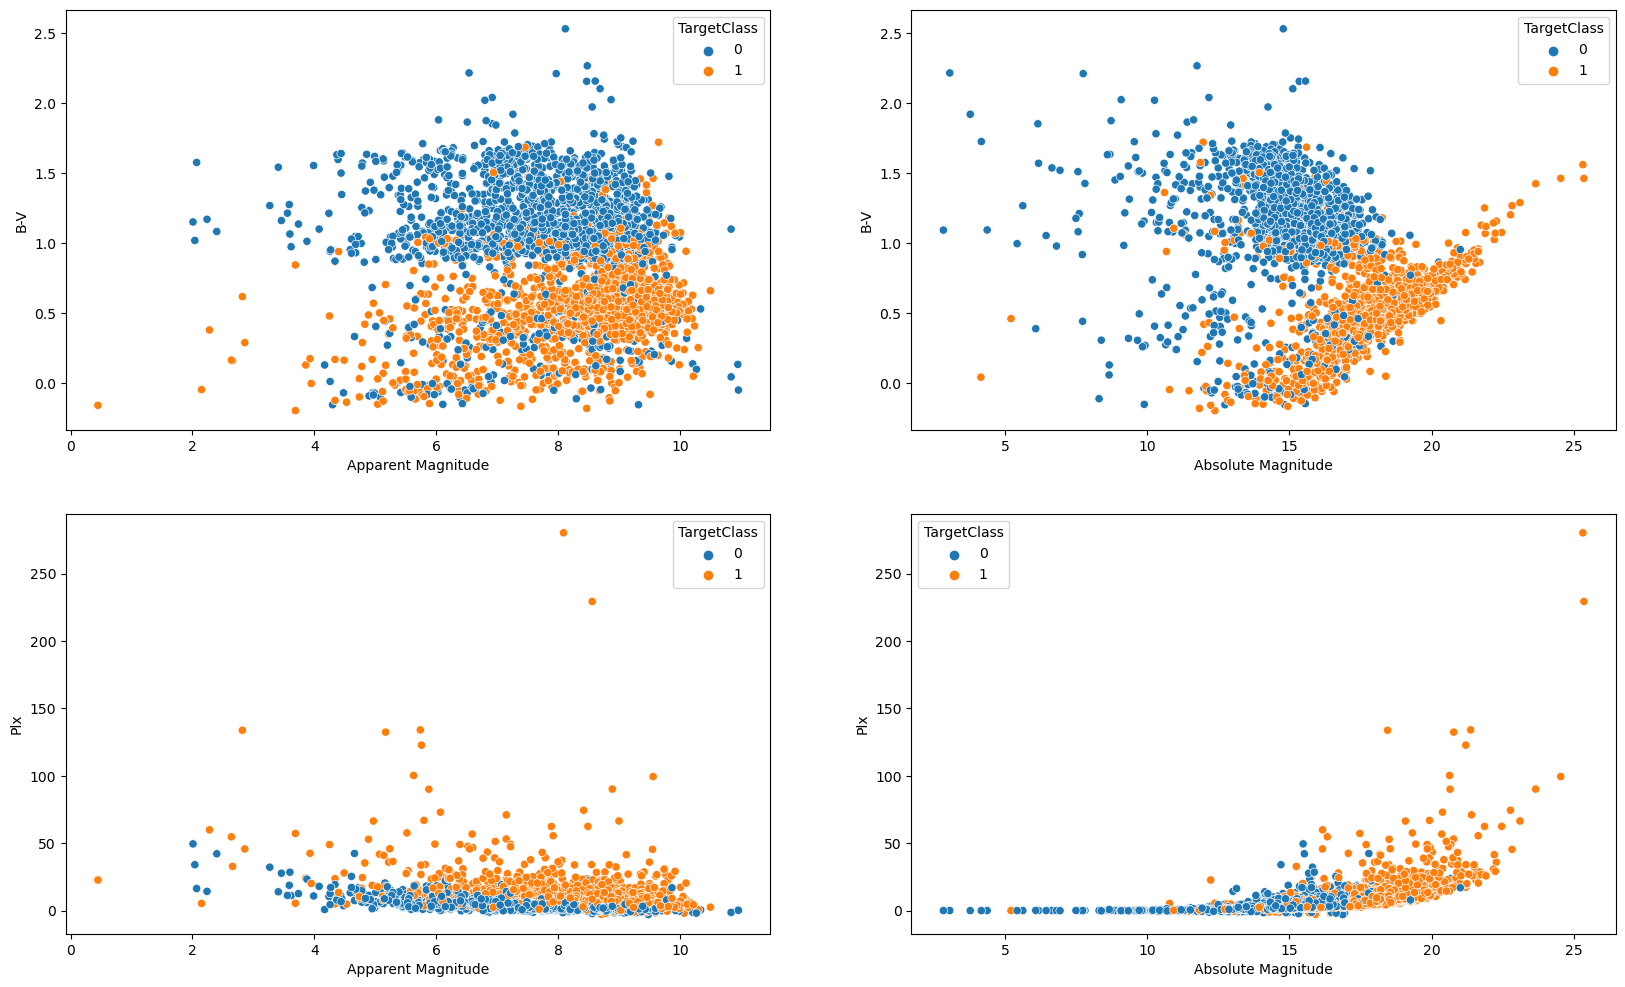

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(20,12))

sns.scatterplot(data = stars_dff, x = 'Vmag', y= 'B-V', ax = axes[0][0], hue = 'TargetClass')
axes[0,0].set_xlabel('Apparent Magnitude')

sns.scatterplot(data = stars_dff, x = 'Amag',  y= 'B-V', ax = axes[0][1], hue = 'TargetClass')
axes[0,1].set_xlabel('Absolute Magnitude')


sns.scatterplot(data = stars_dff, x = 'Vmag', y = 'Plx', ax = axes[1][0], hue='TargetClass')
axes[1,0].set_xlabel('Apparent Magnitude')


sns.scatterplot(data = stars_dff, x = 'Amag', y = 'Plx', ax = axes[1][1], hue = 'TargetClass')
axes[1,1].set_xlabel('Absolute Magnitude')



/tmp/ipykernel_18426/1217659178.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data = stars_dff['Amag'].loc[stars_dff['TargetClass']==0], shade=True, ax = axes[0],label='Dwarf')
/tmp/ipykernel_18426/1217659178.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data = stars_dff['Amag'].loc[stars_dff['TargetClass']==1], shade=True, ax = axes[0],label='Giant')
/tmp/ipykernel_18426/1217659178.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data = stars_dff['Vmag'].loc[stars_dff['TargetClass']==0], shade=True, ax = axes[1],label='Dwarf')
/tmp/ipykernel_18426/1217659178.py:9: FutureWarning: 

`shade` is now deprecate

Text(0.5, 0, 'Apparent Magnitude')

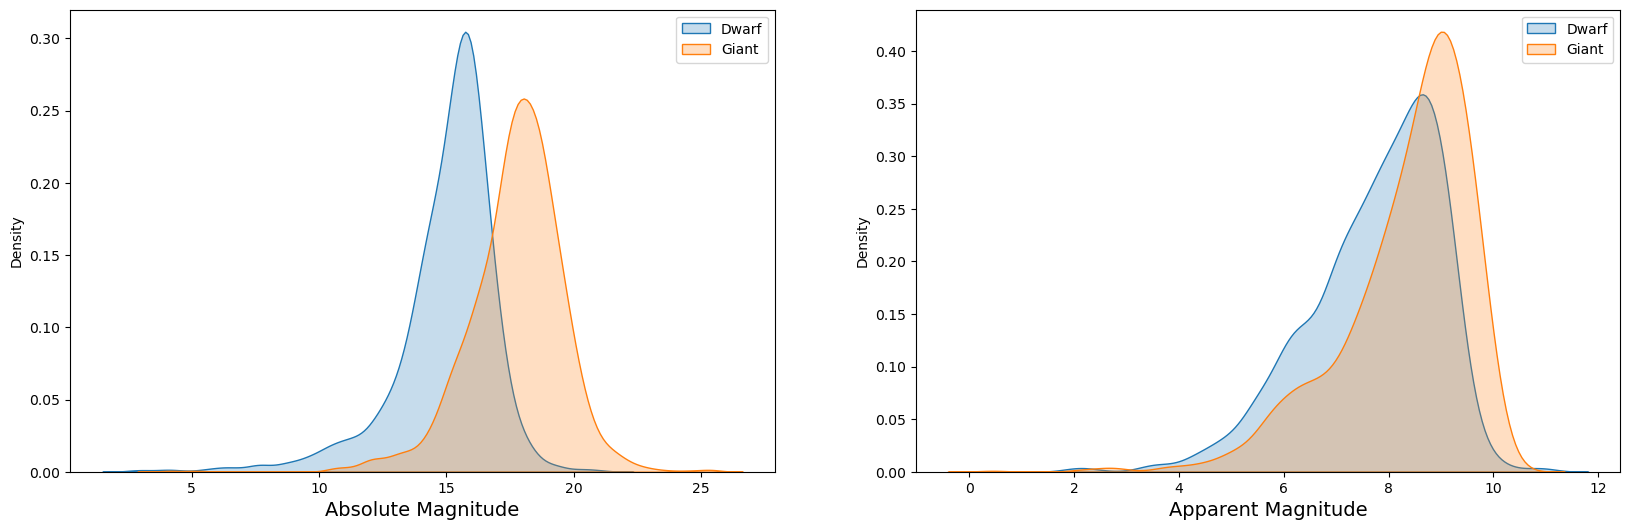

In [22]:
fig, axes = plt.subplots(1,2, figsize=(20,6))

sns.kdeplot(data = stars_dff['Amag'].loc[stars_dff['TargetClass']==0], shade=True, ax = axes[0],label='Dwarf')
sns.kdeplot(data = stars_dff['Amag'].loc[stars_dff['TargetClass']==1], shade=True, ax = axes[0],label='Giant')
axes[0].legend()

axes[0].set_xlabel('Absolute Magnitude', size=14)
sns.kdeplot(data = stars_dff['Vmag'].loc[stars_dff['TargetClass']==0], shade=True, ax = axes[1],label='Dwarf')
sns.kdeplot(data = stars_dff['Vmag'].loc[stars_dff['TargetClass']==1], shade=True, ax = axes[1],label='Giant')
axes[1].legend()

axes[1].set_xlabel('Apparent Magnitude', size=14)

# 4 - Feature Engineering

## 4.1 - Why feature engineering?

If we examine the dataset, we can see that the scatter plots shows an interesting division of the space. Just a small number of stars would be misclasified if we drawed a simple curve in order to separate the two kind of stars. The idea is to expand our features by, for example, calculating the squared value of some columns and also performing some calculations between two columns in order to obtain a third one.

## 4.2 - Working with features

In [23]:
#Let's calculate the squared value of the apparent and absolute magnitudes. The same for the B-V column.

stars_df_eng = stars_dff.copy()

stars_df_eng['Amag_SQ'] = stars_df_eng['Amag']**2
stars_df_eng['Vmag_SQ'] = stars_df_eng['Vmag']**2
stars_df_eng['B-V_SQ'] = stars_df_eng['B-V']**2

In [24]:
#Now let's try adding different values to each other

stars_df_eng['Sum_AV'] = stars_df_eng['Amag'] + stars_df_eng['Vmag']
stars_df_eng['Sub_AV'] = stars_df_eng['Amag'] - stars_df_eng['Vmag']


#more
stars_df_eng['B-V-Amag'] = stars_df_eng['B-V'] - stars_df_eng['Amag']
stars_df_eng['B-V+Amag'] = stars_df_eng['B-V'] + stars_df_eng['Amag']



In [25]:
stars_df_eng.head()

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass,Amag_SQ,Vmag_SQ,B-V_SQ,Sum_AV,Sub_AV,B-V-Amag,B-V+Amag
0,8.23,2.72,1.01,1.294,K2/K3III,15.402843,0,237.247572,67.7329,1.674436,23.632843,7.172843,-14.108843,16.696843
1,7.95,6.12,0.97,1.067,K0III-IV,16.883757,1,285.061250,63.2025,1.138489,24.833757,8.933757,-15.816757,17.950757
3,6.93,0.65,0.66,0.240,B0.5III,10.994566,0,120.880482,48.0249,0.057600,17.924566,4.064566,-10.754566,11.234566
4,6.82,2.82,0.74,1.273,G8/K0III,14.071245,0,197.999936,46.5124,1.620529,20.891245,7.251245,-12.798245,15.344245
5,7.85,4.42,1.13,0.168,B8III,16.077110,0,258.473466,61.6225,0.028224,23.927110,8.227110,-15.909110,16.245110


In [26]:
stars_df_eng['SpType_1st'] = stars_df_eng['SpType'].str[0]



# Create a dictionary to map letters to integers
sp_type_dict = {'O': 0, 'B': 1, 'A': 2, 'F': 3, 'G': 4, 'K': 5, 'M': 6}

# Apply the map() method to the 'SpType_1st' column using the dictionary
stars_df_eng['SpType_num'] = stars_df_eng['SpType_1st'].map(sp_type_dict)

stars_numeric = stars_df_eng.drop(['SpType','SpType_1st'], inplace=False, axis='columns')
#stars_numeric['SpType_num'] = stars_numeric['SpType_num'].astype('int64')
stars_numeric.head()

,Vmag,Plx,e_Plx,B-V,Amag,TargetClass,Amag_SQ,Vmag_SQ,B-V_SQ,Sum_AV,Sub_AV,B-V-Amag,B-V+Amag,SpType_num
0,8.23,2.72,1.01,1.294,15.402843,0,237.247572,67.7329,1.674436,23.632843,7.172843,-14.108843,16.696843,5.0
1,7.95,6.12,0.97,1.067,16.883757,1,285.061250,63.2025,1.138489,24.833757,8.933757,-15.816757,17.950757,5.0
3,6.93,0.65,0.66,0.240,10.994566,0,120.880482,48.0249,0.057600,17.924566,4.064566,-10.754566,11.234566,1.0
4,6.82,2.82,0.74,1.273,14.071245,0,197.999936,46.5124,1.620529,20.891245,7.251245,-12.798245,15.344245,4.0
5,7.85,4.42,1.13,0.168,16.077110,0,258.473466,61.6225,0.028224,23.927110,8.227110,-15.909110,16.245110,1.0


In [27]:
# Select the columns to be standardized (excluding 'SpType_num')
cols_to_scale = ['Vmag', 'Plx', 'e_Plx', 'B-V', 'Amag', 'Amag_SQ', 'Vmag_SQ', 'B-V_SQ', 'Sum_AV', 'Sub_AV']

# Standardize the selected columns
for col in cols_to_scale:
    stars_numeric[col] = stars_numeric[col] / stars_numeric[col].max()

# Drop any rows with missing values (NaN)
stars_numeric = stars_numeric.dropna()

# Convert the 'TargetClass' column to integer type
stars_numeric['TargetClass'] = stars_numeric['TargetClass'].astype('int64')

# Print the first few rows of the standardized DataFrame
print(stars_numeric.head())


       Vmag       Plx     e_Plx       B-V      Amag  TargetClass   Amag_SQ  \
0  0.750912  0.009705  0.604790  0.511462  0.607312            0  0.368828   
1  0.725365  0.021836  0.580838  0.421739  0.665703            1  0.443160   
3  0.632299  0.002319  0.395210  0.094862  0.433500            0  0.187922   
4  0.622263  0.010062  0.443114  0.503162  0.554809            0  0.307813   
5  0.716241  0.015771  0.676647  0.066403  0.633898            0  0.401826   

    Vmag_SQ    B-V_SQ    Sum_AV    Sub_AV   B-V-Amag   B-V+Amag  SpType_num  
0  0.563869  0.261594  0.692887  0.416109 -14.108843  16.696843         5.0  
1  0.526154  0.177864  0.728096  0.518263 -15.816757  17.950757         5.0  
3  0.399802  0.008999  0.525527  0.235793 -10.754566  11.234566         1.0  
4  0.387211  0.253172  0.612506  0.420658 -12.798245  15.344245         4.0  
5  0.513001  0.004409  0.701514  0.477269 -15.909110  16.245110         1.0  


# 5 - Splitting the dataset

In [28]:
#We will use a 20% of the data for the test dataset.
X = stars_numeric.drop(['TargetClass','SpType_num','Plx','Vmag','e_Plx','Sum_AV','Sub_AV','Vmag_SQ'], axis=1, inplace=False)
Y = stars_numeric['SpType_num']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state=1)

In [29]:
X_train

,B-V,Amag,Amag_SQ,B-V_SQ,B-V-Amag,B-V+Amag
2613,0.522530,0.577097,0.333040,0.273037,-13.314499,15.958499
775,0.363636,0.702720,0.493816,0.132231,-16.902603,18.742603
216,0.294862,0.813920,0.662466,0.086943,-19.896885,21.388885
3599,0.526482,0.569432,0.324252,0.277184,-13.110100,15.774100
1387,0.041107,0.631150,0.398350,0.001690,-15.903420,16.111420
...,...,...,...,...,...,...
3000,0.394862,0.633089,0.400802,0.155916,-15.057602,17.055602
998,0.603557,0.633560,0.401399,0.364281,-14.541554,17.595554
1206,0.484585,0.562998,0.316967,0.234823,-13.052932,15.504932
265,0.071937,0.619807,0.384161,0.005175,-15.537735,15.901735


In [30]:
Y_train

2613    5.0
775     4.0
216     4.0
3599    5.0
1387    2.0
       ... 
3000    5.0
998     5.0
1206    5.0
265     2.0
1169    4.0
Name: SpType_num, Length: 2684, dtype: float64

# 6 - Models Development

# 6.1 - KNN Model

In [277]:
n_neigh = 15
K_best = 0
Score_best = 0

for i in range(1,n_neigh):
    KNN = KNeighborsClassifier(n_neighbors=i)
    KNN.fit(X_train,Y_train)
    Y_pred = KNN.predict(X_test)
    if KNN.score(X_test,Y_test) > Score_best:
        Score_best = KNN.score(X_test,Y_test)
        K_best = i
print("The best number of neighbors is {} with a test accuracy of {}%""".format(K_best, (Score_best*100)))


The best number of neighbors is 5 with a test accuracy of 79.88077496274218%


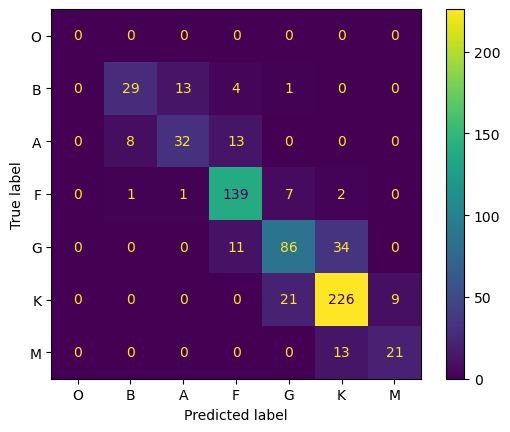

In [278]:
# Define the dictionary to map integers to spectral types
sp_type_dict = {0: 'O', 1: 'B', 2: 'A', 3: 'F', 4: 'G', 5: 'K', 6: 'M'}

# Compute the confusion matrix
matrix = confusion_matrix(Y_test, Y_pred, labels=[0, 1, 2, 3, 4, 5, 6])

# Create the ConfusionMatrixDisplay object with updated labels
cf = ConfusionMatrixDisplay(matrix, display_labels=[sp_type_dict[i] for i in range(7)])

# Plot the confusion matrix
cf.plot()
plt.show()


# 6.2 - Logistic Regression

In [279]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
best_solver = ''
best_score_LR = 0
for i in solvers:
    LogReg = LogisticRegression(solver=i)
    LogReg.fit(X_train, Y_train)
    Y_pred_LR = LogReg.predict(X_test)
    score = LogReg.score(X_test,Y_test)
    
    if score > best_score_LR:
        best_score_LR = score
        best_solver = i
print('The best solver for the Logistic Regression is {}, with a {}% of accuracy in the test set.'.format(best_solver, best_score_LR*100))


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The best solver for the Logistic Regression is newton-cg, with a 78.9865871833085% of accuracy in the test set.


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


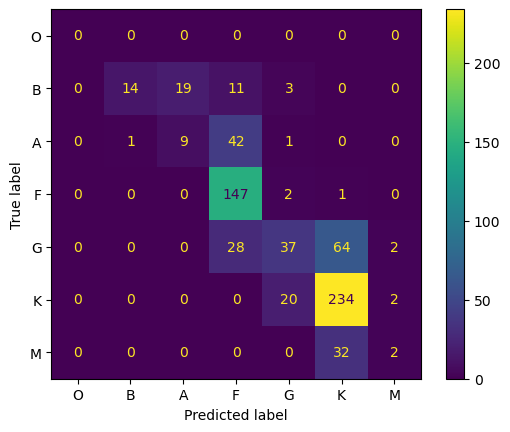

In [281]:
matrix_LR = confusion_matrix(Y_test, Y_pred_LR, labels=[0, 1, 2, 3, 4, 5, 6])

# Create the ConfusionMatrixDisplay object with updated labels
cf = ConfusionMatrixDisplay(matrix_LR, display_labels=[sp_type_dict[i] for i in range(7)])

# Plot the confusion matrix
cf.plot()
plt.show()


# Classical SVC v.s. Quantum SVC

In [32]:
# General Imports
import numpy as np
import time
import pandas as pd
from functools import reduce

# Visualisation Imports
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit Imports
from sklearn.preprocessing import *
from sklearn.decomposition import *
from sklearn.model_selection import *
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Qiskit Imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit import *
from qiskit.opflow import *
from qiskit.utils import *
from qiskit.circuit import *
from qiskit.circuit.library import *
from qiskit.algorithms.optimizers import *
from qiskit_machine_learning.neural_networks import *
from qiskit_machine_learning.algorithms.classifiers import *
from qiskit_machine_learning.algorithms.regressors import *
from qiskit_machine_learning.datasets import *

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from qiskit import BasicAer
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
#from qiskit_machine_learning.kernels import FidelityQuantumKernel

seed = 12345
algorithm_globals.random_seed = seed

# Loading your IBM Quantum account(s)
# provider = IBMQ.load_account()

In [33]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.23.2', 'qiskit-aer': '0.11.2', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.20.1', 'qiskit': '0.41.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': '0.5.0'}

In [50]:
#We will use a 20% of the data for the test dataset.
X = stars_numeric.drop(['TargetClass','SpType_num','Plx','Vmag','e_Plx','Sum_AV','Sub_AV','Vmag_SQ'], axis=1, inplace=False)
Y = stars_numeric['SpType_num']
sample_train, sample_test, label_train, label_test = train_test_split(X,Y, test_size = 0.15, random_state=1)
print("Original Size:")
print(sample_train.shape,sample_test.shape)
print()
# Reduce dimensions
n_dim = X_train.shape[1]
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# Normalise
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Scale
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

print("After Cut:")
# Select
train_size = 2851
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 504
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]
print(sample_train.shape,sample_test.shape)

Original Size:
(2851, 6) (504, 6)

After Cut:
(2851, 6) (504, 6)


In [51]:
zz_map = ZZFeatureMap(feature_dimension=len(sample_train[0]), reps=2, entanglement='full', insert_barriers=True)
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))

In [52]:
zz_circuit = zz_kernel.construct_circuit(sample_train[0], sample_train[1])
#zz_circuit.decompose().decompose().draw(output='mpl')

In [53]:
#zz_circuit.draw('mpl')

In [ ]:
start = time.perf_counter()
matrix_train = zz_kernel.evaluate(x_vec=sample_train)
matrix_test = zz_kernel.evaluate(x_vec=sample_test, y_vec=sample_train)
end = time.perf_counter()
print(matrix_train.shape,matrix_test.shape)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(np.log(matrix_train)),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()

print(round(end-start,2),' (s)')

In [ ]:
zzpc_svc = SVC(kernel='precomputed')
zzpc_svc.fit(matrix_train, label_train)
zzpc_score = zzpc_svc.score(matrix_test, label_test)

print(f'Precomputed kernel classification test score: {zzpc_score}')

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Obtain the predicted labels for the val data
predicted_labels = zzpc_svc.predict(matrix_test)

# Calculate the accuracy score using the true labels and the predicted labels
accuracy = accuracy_score(label_test, predicted_labels)

# Calculate the F1 score using the true labels and the predicted labels
f1 = f1_score(label_test, predicted_labels, average='weighted')

# Calculate the sensitivity and specificity scores using the true labels and the predicted labels
sensitivity = recall_score(label_test, predicted_labels, average='weighted')
specificity = precision_score(label_test, predicted_labels, average='weighted', zero_division=1)

# Generate the confusion matrix using the true labels and the predicted labels
cm = confusion_matrix(label_test, predicted_labels, labels=[0,1,2,3,4,5,6])

# Define the dictionary to map integers to spectral types
sp_type_dict = {0: 'O', 1: 'B', 2: 'A', 3: 'F', 4: 'G', 5: 'K', 6: 'M'}

# Compute the confusion matrix
matrix = confusion_matrix(label_test, predicted_labels, labels=[0, 1, 2, 3, 4, 5, 6])

# Create the ConfusionMatrixDisplay object with updated labels
cf = ConfusionMatrixDisplay(matrix, display_labels=[sp_type_dict[i] for i in range(7)])

# Plot the confusion matrix
cf.plot()
plt.show()

# Print the accuracy, F1 score, sensitivity, specificity, confusion matrix, and precomputed kernel classification val score
print(f'Accuracy: {round(accuracy,3)}')
print(f'F1 score: {round(f1,3)}')
print(f'Sensitivity: {round(sensitivity,3)}')
print(f'Specificity: {round(specificity,3)}')
print(f'Confusion matrix:\n{cm}')


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

classical_kernels = ['linear', 'poly', 'rbf', 'sigmoid']

best_kernel = None
best_score = 0

for kernel in classical_kernels:
    classical_svc = SVC(kernel=kernel)
    classical_svc.fit(sample_train, label_train)
    classical_score = classical_svc.score(sample_test, label_test)

    print('%s kernel classification test score:  %0.2f' % (kernel, classical_score))
    
    if classical_score > best_score:
        best_kernel = kernel
        best_score = classical_score

# Train the SVC model with the best kernel.
best_svc = SVC(kernel=best_kernel)
best_svc.fit(sample_train, label_train)

# Test the model on the test data.
y_pred = best_svc.predict(sample_test)

# Calculate the confusion matrix and performance metrics.

accuracy = accuracy_score(label_test, y_pred)
f1 = f1_score(label_test, y_pred, average='weighted')

# Calculate the sensitivity and specificity scores using the true labels and the predicted labels
sensitivity = recall_score(label_test, y_pred, average='weighted')
specificity = precision_score(label_test, y_pred, average='weighted', zero_division=1)

print()

# Output the results.
print(f'Accuracy: {round(accuracy,3)}')
print(f'F1 score: {round(f1,3)}')
print(f'Sensitivity: {round(sensitivity,3)}')
print(f'Specificity: {round(specificity,3)}')
print(f'Confusion matrix:\n{cm}')

# Generate the confusion matrix using the true labels and the predicted labels
cm = confusion_matrix(label_test, y_pred, labels=[0,1,2,3,4,5,6])

# Define the dictionary to map integers to spectral types
sp_type_dict = {0: 'O', 1: 'B', 2: 'A', 3: 'F', 4: 'G', 5: 'K', 6: 'M'}

# Compute the confusion matrix
matrix = confusion_matrix(label_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6])

# Create the ConfusionMatrixDisplay object with updated labels
cf = ConfusionMatrixDisplay(matrix, display_labels=[sp_type_dict[i] for i in range(7)])

# Plot the confusion matrix
cf.plot()
plt.show()

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table